In [80]:
import pandas as pd 
import numpy as np 
import configparser
import os
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import nltk 

from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne

config = configparser.ConfigParser()
config.read("..//env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
base_path = config['DEFAULT']['base_path']
code_dir = config['DEFAULT']['code_dir']

data_prefix = 'Maha'
out_path = f'{output_dir}/{data_prefix}'
OHCO = ['book_id','chap_id','sec_id','para_num', 'sent_num', 'token_num']


os.chdir(code_dir)
import preprocess
import bow_analysis
os.chdir(base_path + "//notebooks")

SENTS = OHCO[:5]
PARA = OHCO[:4]
SECS = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [100]:
CORPUS = pd.read_csv(fr"{output_dir}\F2\{data_prefix}-CORPUS.csv", sep="|").set_index(OHCO)
VOCAB = pd.read_csv(fr"{output_dir}\CHAP_BOW\{data_prefix}-VOCAB2.csv", sep="|").set_index('term_str')

SENT_VOCAB = pd.read_csv(fr"{output_dir}\SA_Results\{data_prefix}-Senti_VOCAB.csv",sep = "|")

In [82]:
character_names = [
    'yudhisthira','bhima','arjuna',
    # 'nakula','sahadeva',
    'draupadi','kunti',
    'krishna',
    # 'kesava',
    # 'bhishma','drona',
    'karna',
    'duryodhana','gandhari'
]

In [83]:

cfg = {'figsize': (20,5)}
# for i in CORPUS.reset_index()['book_id'].unique():
# print(i)
# BOOK = CORPUS.loc[i].copy()
charbook = CORPUS[CORPUS['term_str'].apply(lambda x: x in character_names)]

TTM = pd.get_dummies(charbook['term_str'], columns=['term_str'], prefix='', prefix_sep='')\
    .reset_index(drop=True).iloc[:,:].astype('int')
TTM.index.name = 'time_id'



In [84]:
# Step 1: Filter by character names
CORPUS_CHAR = CORPUS[CORPUS['term_str'].isin(character_names)].copy()

# Step 2: Create a dataframe of all unique OHCO combinations (including paragraphs without characters)
CORPUS_ALL_OHCO = CORPUS.reset_index().drop_duplicates(subset=['book_id', 'chap_id', 'sec_id', 'para_num', 'sent_num'])

# Step 3: Merge the filtered corpus with the all-possible OHCO combinations, filling missing rows for paragraphs without characters
CORPUS_CHAR_MIN = pd.merge(CORPUS_ALL_OHCO[['book_id', 'chap_id', 'sec_id', 'para_num', 'sent_num']]
                           , CORPUS_CHAR, how='left', on=['book_id', 'chap_id', 'sec_id', 'para_num', 'sent_num'])

CORPUS_CHAR_MIN


,book_id,chap_id,sec_id,para_num,sent_num,pos_tuple,pos,token_str,term_str,pos_group
0,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,NaN,NaN,NaN,NaN,NaN
2,1,1,1,0,2,NaN,NaN,NaN,NaN,NaN
3,1,1,1,0,3,NaN,NaN,NaN,NaN,NaN
4,1,1,1,0,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
128470,18,1,5,0,143,NaN,NaN,NaN,NaN,NaN
128471,18,1,5,0,144,NaN,NaN,NaN,NaN,NaN
128472,18,1,5,0,145,NaN,NaN,NaN,NaN,NaN
128473,18,1,5,0,146,NaN,NaN,NaN,NaN,NaN


In [85]:
[i for i in character_names if i not in TTM.columns]

[]

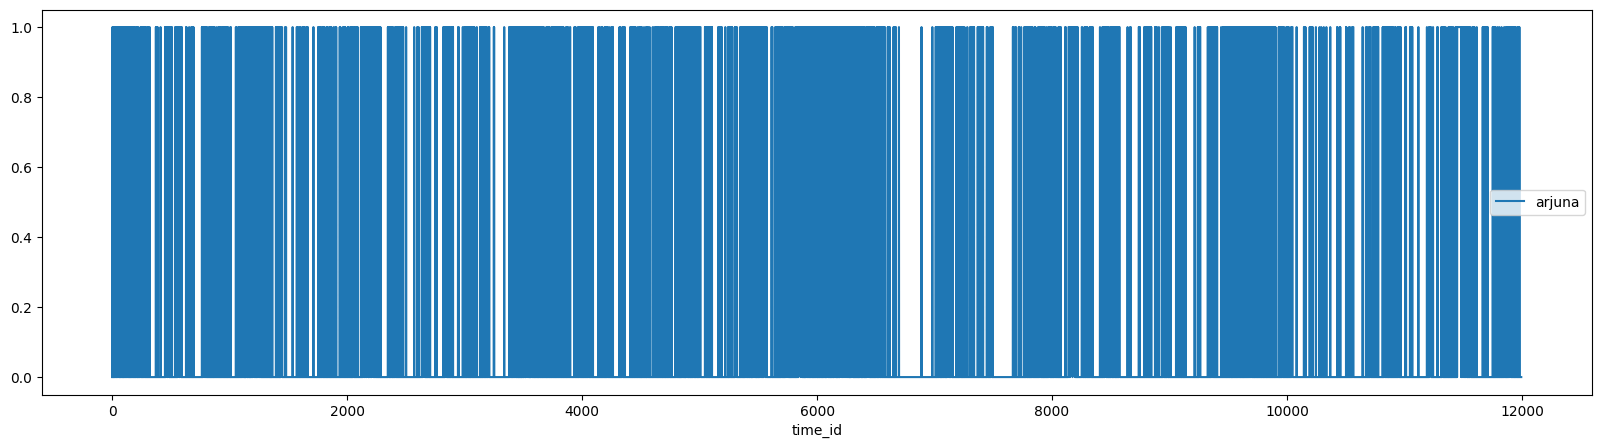

In [86]:
TTM[['arjuna']].plot(**cfg);

In [87]:
B = CORPUS_CHAR_MIN['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
B

,offset,term_str
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
128470,128470,NaN
128471,128471,NaN
128472,128472,NaN
128473,128473,NaN


In [88]:
def plot_words(words, book):    
    
    X = book[book.term_str.isin(words)]
    
    plt.figure(figsize=(22, len(words)))
    
    ax = sns.stripplot(y='term_str', x='offset', data=X, orient='h', marker=".", color='navy', size=15, jitter=0)
    ax.set_title('Dispersion Plots', size=30, pad=20)
    ax.set_xlabel('Narrative Time', size=20)
    ax.set_ylabel('Term', size=20)
    
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.tight_layout()
    plt.show()

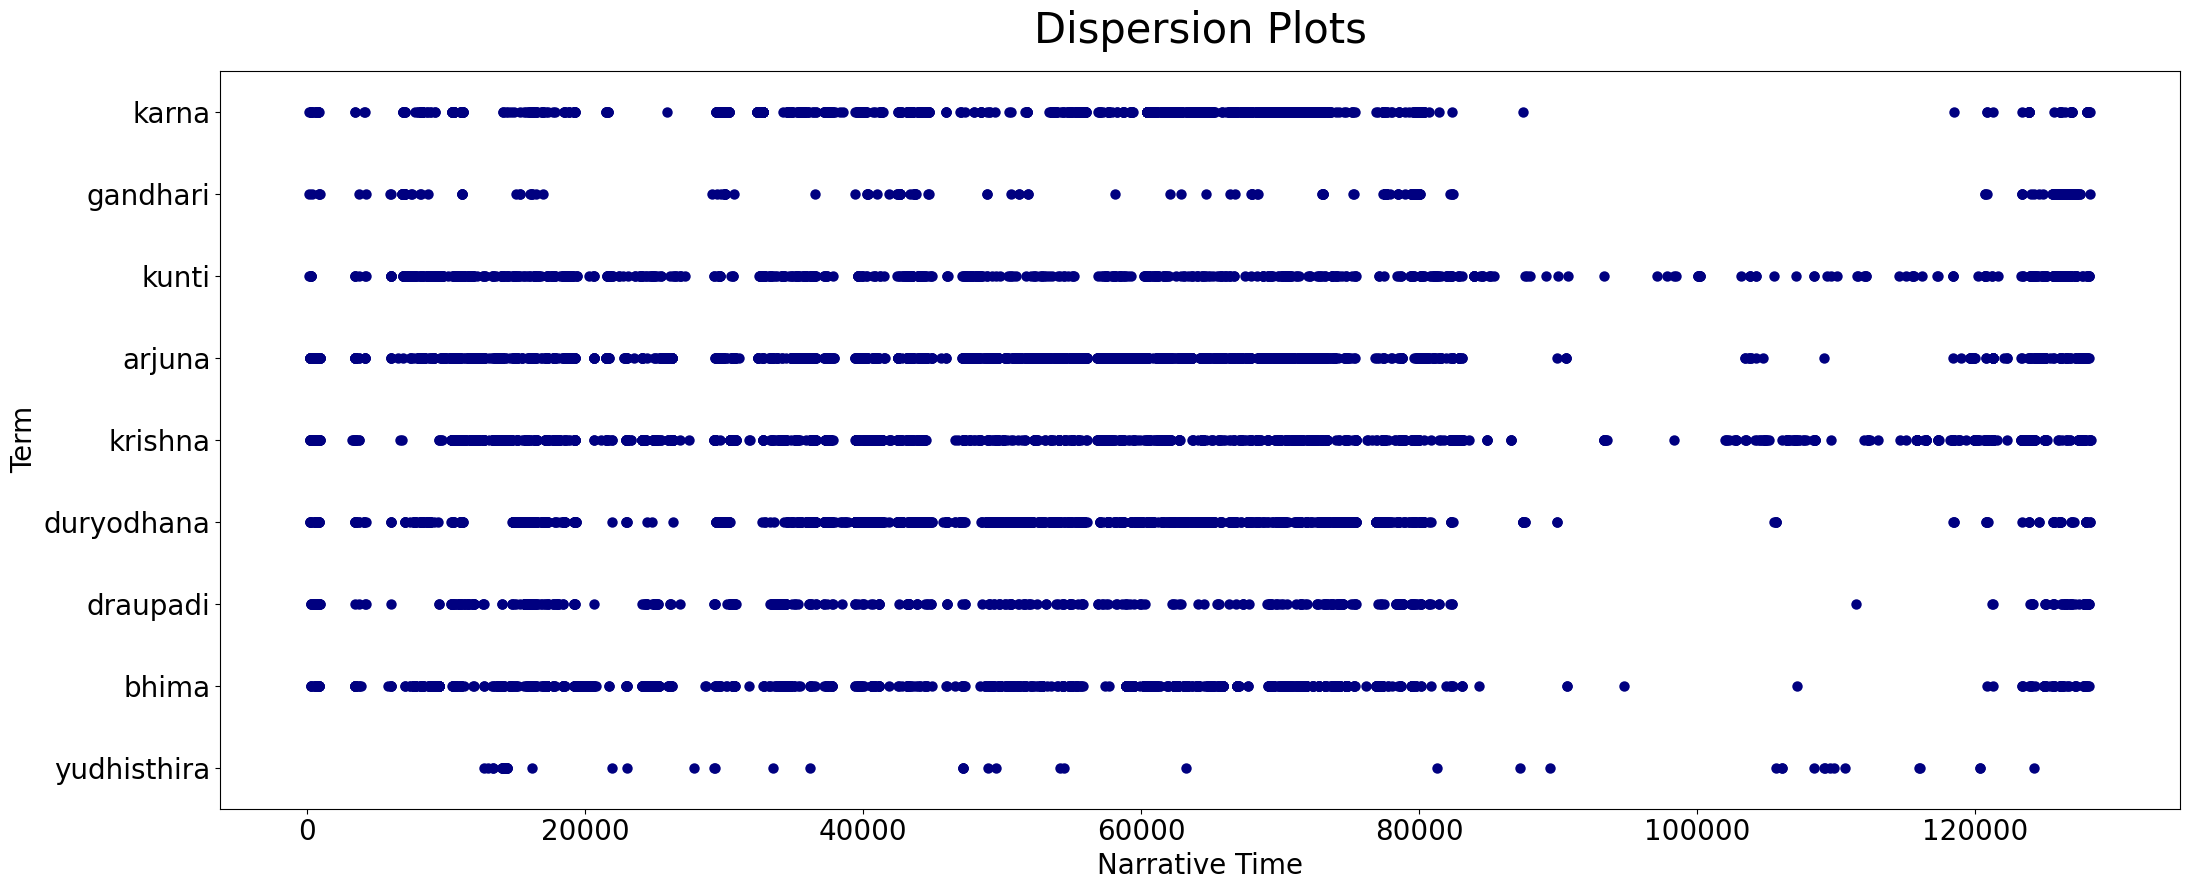

In [89]:
plot_words(character_names, B)

In [90]:
import numpy as np
import scipy as sp
from sklearn.neighbors import KernelDensity as KDE
from nltk.corpus import stopwords

kde_kernel = 'gaussian'
kde_bandwidth = 2000
kde_samples = 1000

In [91]:
X = B.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()
X['x'] = X.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [92]:
scale_max = B.offset.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
X['kde'] = X.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
X['scores'] = X.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [93]:
PLOTS = X.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

In [119]:
PLOTS

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
term_str,,,,,,,,,,,,,,,,,,,,,
arjuna,7.164391e-04,7.294884e-04,7.401047e-04,7.482132e-04,7.537700e-04,7.567638e-04,7.572150e-04,7.551760e-04,7.507298e-04,7.439882e-04,...,0.000993,0.000960,0.000925,0.000890,0.000854,0.000818,0.000782,0.000746,0.000709,0.000673
bhima,3.490449e-04,3.594386e-04,3.690037e-04,3.776914e-04,3.854653e-04,3.923014e-04,3.981887e-04,4.031298e-04,4.071404e-04,4.102495e-04,...,0.000665,0.000647,0.000628,0.000608,0.000586,0.000564,0.000542,0.000518,0.000494,0.000470
draupadi,1.240608e-03,1.265062e-03,1.285096e-03,1.300528e-03,1.311228e-03,1.317128e-03,1.318217e-03,1.314542e-03,1.306209e-03,1.293378e-03,...,0.001812,0.001786,0.001755,0.001720,0.001680,0.001636,0.001589,0.001538,0.001484,0.001427
duryodhana,4.254544e-04,4.367249e-04,4.468633e-04,4.558158e-04,4.635441e-04,4.700266e-04,4.752580e-04,4.792497e-04,4.820296e-04,4.836409e-04,...,0.000360,0.000352,0.000342,0.000333,0.000322,0.000311,0.000300,0.000288,0.000276,0.000264
gandhari,4.858678e-04,4.986227e-04,5.102561e-04,5.207571e-04,5.301407e-04,5.384477e-04,5.457466e-04,5.521330e-04,5.577296e-04,5.626858e-04,...,0.007598,0.007378,0.007138,0.006880,0.006608,0.006324,0.006030,0.005728,0.005422,0.005114
karna,2.267881e-04,2.310229e-04,2.344865e-04,2.371552e-04,2.390158e-04,2.400658e-04,2.403140e-04,2.397799e-04,2.384938e-04,2.364963e-04,...,0.000272,0.000268,0.000263,0.000258,0.000253,0.000246,0.000240,0.000232,0.000225,0.000216
krishna,5.709418e-04,5.832790e-04,5.937902e-04,6.023961e-04,6.090397e-04,6.136863e-04,6.163246e-04,6.169656e-04,6.156428e-04,6.124101e-04,...,0.000841,0.000820,0.000797,0.000774,0.000751,0.000726,0.000701,0.000675,0.000649,0.000622
kunti,1.846761e-04,1.897250e-04,1.946080e-04,1.993613e-04,2.040313e-04,2.086749e-04,2.133598e-04,2.181643e-04,2.231774e-04,2.284986e-04,...,0.002135,0.002063,0.001987,0.001908,0.001827,0.001743,0.001658,0.001572,0.001485,0.001399
yudhisthira,1.539016e-12,2.327512e-12,3.506053e-12,5.260476e-12,7.861640e-12,1.170266e-11,1.735168e-11,2.562629e-11,3.769804e-11,5.523865e-11,...,0.000151,0.000137,0.000123,0.000110,0.000098,0.000087,0.000077,0.000068,0.000060,0.000052


In [94]:
FIG = dict(figsize=(15, 5))

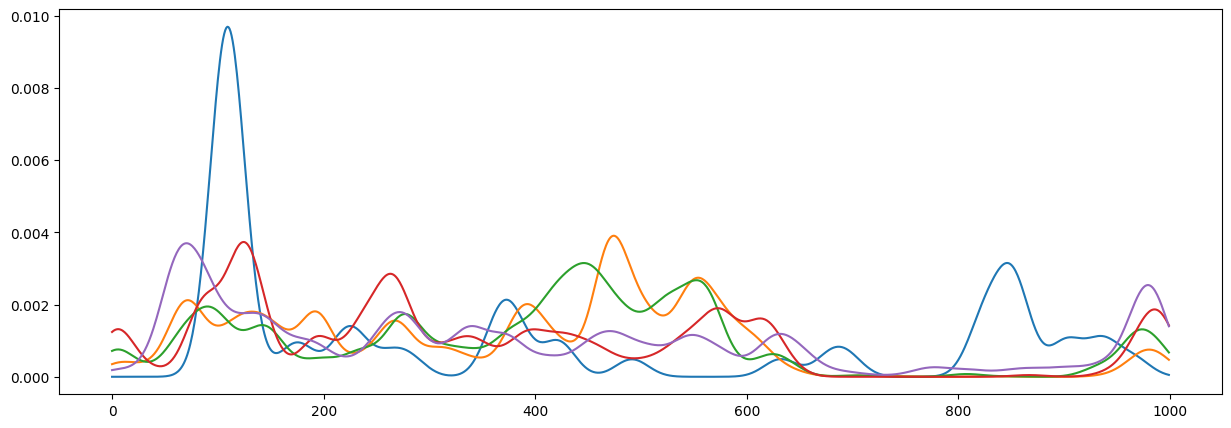

In [95]:
for i in character_names[:5]:
    PLOTS.loc[i].plot(**FIG);

In [96]:
fig = go.Figure()
for i, c in enumerate(character_names):
    fig.add_trace(go.Scatter(
        x=PLOTS.columns,  
        y=PLOTS.loc[c],
        mode='lines',
        name=c,
        # fill='tozeroy',
    ))

fig.update_layout(
    title='KDE Area Plot of Character Mentions',
    xaxis_title='Offset / Context Scale',
    yaxis_title='Density',
    width=1000,
    height=500,
    template='plotly_white'
)

fig.show()


In [97]:
PLOTS

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
term_str,,,,,,,,,,,,,,,,,,,,,
arjuna,7.164391e-04,7.294884e-04,7.401047e-04,7.482132e-04,7.537700e-04,7.567638e-04,7.572150e-04,7.551760e-04,7.507298e-04,7.439882e-04,...,0.000993,0.000960,0.000925,0.000890,0.000854,0.000818,0.000782,0.000746,0.000709,0.000673
bhima,3.490449e-04,3.594386e-04,3.690037e-04,3.776914e-04,3.854653e-04,3.923014e-04,3.981887e-04,4.031298e-04,4.071404e-04,4.102495e-04,...,0.000665,0.000647,0.000628,0.000608,0.000586,0.000564,0.000542,0.000518,0.000494,0.000470
draupadi,1.240608e-03,1.265062e-03,1.285096e-03,1.300528e-03,1.311228e-03,1.317128e-03,1.318217e-03,1.314542e-03,1.306209e-03,1.293378e-03,...,0.001812,0.001786,0.001755,0.001720,0.001680,0.001636,0.001589,0.001538,0.001484,0.001427
duryodhana,4.254544e-04,4.367249e-04,4.468633e-04,4.558158e-04,4.635441e-04,4.700266e-04,4.752580e-04,4.792497e-04,4.820296e-04,4.836409e-04,...,0.000360,0.000352,0.000342,0.000333,0.000322,0.000311,0.000300,0.000288,0.000276,0.000264
gandhari,4.858678e-04,4.986227e-04,5.102561e-04,5.207571e-04,5.301407e-04,5.384477e-04,5.457466e-04,5.521330e-04,5.577296e-04,5.626858e-04,...,0.007598,0.007378,0.007138,0.006880,0.006608,0.006324,0.006030,0.005728,0.005422,0.005114
karna,2.267881e-04,2.310229e-04,2.344865e-04,2.371552e-04,2.390158e-04,2.400658e-04,2.403140e-04,2.397799e-04,2.384938e-04,2.364963e-04,...,0.000272,0.000268,0.000263,0.000258,0.000253,0.000246,0.000240,0.000232,0.000225,0.000216
krishna,5.709418e-04,5.832790e-04,5.937902e-04,6.023961e-04,6.090397e-04,6.136863e-04,6.163246e-04,6.169656e-04,6.156428e-04,6.124101e-04,...,0.000841,0.000820,0.000797,0.000774,0.000751,0.000726,0.000701,0.000675,0.000649,0.000622
kunti,1.846761e-04,1.897250e-04,1.946080e-04,1.993613e-04,2.040313e-04,2.086749e-04,2.133598e-04,2.181643e-04,2.231774e-04,2.284986e-04,...,0.002135,0.002063,0.001987,0.001908,0.001827,0.001743,0.001658,0.001572,0.001485,0.001399
yudhisthira,1.539016e-12,2.327512e-12,3.506053e-12,5.260476e-12,7.861640e-12,1.170266e-11,1.735168e-11,2.562629e-11,3.769804e-11,5.523865e-11,...,0.000151,0.000137,0.000123,0.000110,0.000098,0.000087,0.000077,0.000068,0.000060,0.000052


In [98]:
kde_corr = PLOTS.T.corr(method='pearson')
kde_corr

term_str,arjuna,bhima,draupadi,duryodhana,gandhari,karna,krishna,kunti,yudhisthira
term_str,,,,,,,,,
arjuna,1.000000,0.807477,0.527224,0.689155,0.034985,0.668963,0.530425,0.464692,0.056722
bhima,0.807477,1.000000,0.512963,0.696049,0.002234,0.702301,0.450901,0.496318,0.043447
draupadi,0.527224,0.512963,1.000000,0.534951,0.282576,0.162065,0.722634,0.594236,0.442189
duryodhana,0.689155,0.696049,0.534951,1.000000,0.135438,0.576709,0.531117,0.281462,-0.032883
gandhari,0.034985,0.002234,0.282576,0.135438,1.000000,-0.037056,0.145534,0.421728,-0.132176
karna,0.668963,0.702301,0.162065,0.576709,-0.037056,1.000000,0.203677,0.105205,-0.212119
krishna,0.530425,0.450901,0.722634,0.531117,0.145534,0.203677,1.000000,0.574118,0.557609
kunti,0.464692,0.496318,0.594236,0.281462,0.421728,0.105205,0.574118,1.000000,0.247227
yudhisthira,0.056722,0.043447,0.442189,-0.032883,-0.132176,-0.212119,0.557609,0.247227,1.000000


In [99]:
kde_corr_masked = kde_corr.copy()
kde_corr_masked.values[np.triu_indices_from(kde_corr_masked, k=0)] = np.nan

fig = px.imshow(
    kde_corr_masked,
    labels=dict(x="Character", y="Character", color="Correlation"),
    x=kde_corr.columns,
    y=kde_corr.index,
    color_continuous_scale='RdBu',
    zmin=-1, zmax=1,
    title="KDE Curve Correlation"
)
fig.update_layout(width=800, height=800)
fig.show()

In [134]:
T = CORPUS[CORPUS['term_str'].isnull()==False].reset_index().merge(SENT_VOCAB, on='term_str', how='left').fillna(0)
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
T_sents = T.groupby(SENTS)[emo_cols].mean()
T_sents['sent_str'] = T.groupby(SENTS)['term_str'].apply(lambda x: x.str.cat(sep=' '))
T_sents['uniq_sent_str'] = T.groupby(SENTS)['term_str'].apply(lambda x: " ".join(list(set(x))))
T_sents.head()

anger  anticipation  disgust  fear  \
book_id chap_id sec_id para_num sent_num                                       
1       1       1      0        0           0.0      0.000000      0.0   0.0   
                                1           0.0      0.000000      0.0   0.0   
                                2           0.0      0.000000      0.0   0.0   
                                3           0.0      0.000000      0.0   0.0   
                                4           0.0      0.066667      0.0   0.0   

                                               joy  sadness  surprise  \
book_id chap_id sec_id para_num sent_num                                
1       1       1      0        0         0.000000      0.0  0.000000   
                                1         0.041667      0.0  0.000000   
                                2         0.000000      0.0  0.000000   
                                3         0.034483      0.0  0.034483   
                                4         0.100000      0.0  0.000000   

                                             trust  sentiment  \
book_id chap_id sec_id para_num sent_num                        
1       1       1      0        0         0.000000   0.000000   
                                1         0.083333   0.083333   
                                2         0.023256   0.023256   
                                3         0.034483   0.034483   
                                4         0.033333   0.100000   

                                                                                   sent_str  \
book_id chap_id sec_id para_num sent_num                                                      
1       1       1      0        0                                     anukramanika parva om   
                                1         having bowed down to narayana and nara the mos...   
                                2         ugrasrava the son of lomaharshana surnamed sau...   
                                3         those ascetics wishing to hear his wonderful n...   
                                4         having been entertained with due respect by th...   

                                                                              uniq_sent_str  
book_id chap_id sec_id para_num sent_num                                                     
1       1       1      0        0                                     anukramanika parva om  
                                1         most jaya nara narayana bowed goddess word mal...  
                                2         at sitting bending their of sacrifice lomahars...  
                                3         at ascetics arrived him recluse of those began...  
                                4         munis saluted holy all progress their of and m...

In [162]:
character_names2 = [
   'arjuna', 'krishna',
    'karna',
    'duryodhana'
]

char_appear = CORPUS[['term_str']].reset_index()\
    .merge(pd.DataFrame(data = {'term_str':character_names}), 
           how='right', on="term_str")\
    .drop("token_num", axis=1).drop_duplicates()\
    .set_index(OHCO[:-1])\
    .rename(columns = {'term_str':'character'})
char_appear

character
book_id chap_id sec_id para_num sent_num             
2       1       1      0        47        yudhisthira
        2       7      0        0         yudhisthira
                12     0        53        yudhisthira
                                54        yudhisthira
        4       23     0        52        yudhisthira
...                                               ...
15      3       38     0        27           gandhari
16      1       1      0        84           gandhari
                3      0        31           gandhari
                5      0        17           gandhari
18      1       4      0        18           gandhari

[11715 rows x 1 columns]

In [163]:
SENT_CHAR = T_sents.join(char_appear, how="outer")
SENT_CHAR.sample(2)

,,,,,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment,sent_str,uniq_sent_str,character
book_id,chap_id,sec_id,para_num,sent_num,,,,,,,,,,,,
3,2,10,0,60,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055556,and fried with anger bhima seized the rakshasa...,rut fried the bhima another anger arms one wit...,bhima
13,1,29,0,49,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,o son of sudeva let thy fears be dispelled,thy sudeva be dispelled o let fears son of,NaN


In [164]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
SENT_CHAR[['pos','neg','neu','compound']] = SENT_CHAR['sent_str'].apply(analyser.polarity_scores).apply(pd.Series)

In [165]:
# Get unique sentence order
sent_order = (
    SENT_CHAR.reset_index()\
    [['book_id','chap_id','sec_id','para_num','sent_num']]
    .drop_duplicates()
    .sort_values(by=['book_id','chap_id','sec_id','para_num','sent_num'])
    .reset_index(drop=True)
)
sent_order['global_idx'] = sent_order.index

# Merge back to SENT_CHAR
SENT_CHAR = SENT_CHAR.merge(sent_order, on=['book_id','chap_id','sec_id','para_num','sent_num'], how='left')


In [166]:
window = 274
SENT_CHAR['compound_smooth'] = (
    SENT_CHAR
    .groupby('character')['compound']
    .transform(lambda x: x.rolling(window, min_periods=1).mean())
)

target_ohco = (6, 1, 1, 0, 0)

# Filter the exact row
target_row = SENT_CHAR[
    (SENT_CHAR['book_id'] == target_ohco[0]) &
    (SENT_CHAR['chap_id'] == target_ohco[1]) &
    (SENT_CHAR['sec_id'] == target_ohco[2]) &
    (SENT_CHAR['para_num'] == target_ohco[3]) &
    (SENT_CHAR['sent_num'] == target_ohco[4])
]

target_ohco2 = (11, 1, 1, 0, 0)

# Filter the exact row
target_row2 = SENT_CHAR[
    (SENT_CHAR['book_id'] == target_ohco2[0]) &
    (SENT_CHAR['chap_id'] == target_ohco2[1]) &
    (SENT_CHAR['sec_id'] == target_ohco2[2]) &
    (SENT_CHAR['para_num'] == target_ohco2[3]) &
    (SENT_CHAR['sent_num'] == target_ohco2[4])
]

# Get global index
target_idx = target_row['global_idx'].values[0]
target_idx2 = target_row2['global_idx'].values[0]

# Filter top characters (if needed)
top_chars = SENT_CHAR['character'].value_counts().head(10).index
df_plot = SENT_CHAR[SENT_CHAR['character'].isin(top_chars)]

# Plot using Plotly
fig = px.line(
    df_plot,
    x='global_idx',
    y='compound_smooth',
    color='character',
    title='Character-wise Sentiment Timeline (Compound Score)',
    labels={'global_idx': 'Narrative Progression', 'compound_smooth': 'Smoothed Sentiment'},
    template='plotly_white'
)

fig.add_hline(
    y=0,
    line_dash='dot',
    line_color='gray',
    annotation_text='Neutral Sentiment',
    annotation_position='top left'
)

fig.add_vline(
    x=target_idx,
    line_color='red',
    line_dash='dash',
    annotation_text='Start of War',
    annotation_position='top left'
)
fig.add_vline(
    x=target_idx2,
    line_color='red',
    line_dash='dash',
    annotation_text='End of War',
    annotation_position='top left'
)
# Optional: Add war markers
# fig.add_vline(x=5000, line_dash='dash', line_color='red', annotation_text='War Starts')  # example value
# fig.add_vline(x=7000, line_dash='dash', line_color='red', annotation_text='War Ends')    # example value

fig.update_layout(
    height=600,
    width=1000,
    legend_title_text='Character',
    hovermode='x unified'
)

fig.show()

In [175]:
# Step 1: Group by character and compute mean emotion scores
char_emo = SENT_CHAR.groupby('character')[emo_cols].mean()

# Step 2: Reset index to long format for plotly
char_emo_long = char_emo.reset_index().melt(id_vars='character', 
                                             var_name='emotion', 
                                             value_name='score')

# Step 3: Plot heatmap using Plotly
fig = px.imshow(
    char_emo.values,
    labels=dict(x="Emotion", y="Character", color="Avg Score"),
    x=char_emo.columns,
    y=char_emo.index,
    aspect="auto",
    color_continuous_scale='RdBu_r'
)

fig.update_layout(
    title="Character vs Emotion Heatmap (Mean Scores)",
    xaxis_title="Emotion",
    yaxis_title="Character",
    width=75 * len(char_emo),
    height=50 * len(char_emo),  # dynamic height
    margin=dict(l=120, r=20, t=50, b=20),
    yaxis=dict(tickmode='array', tickvals=character_names)
)

fig.show()

In [176]:
character_names

['yudhisthira',
 'bhima',
 'arjuna',
 'draupadi',
 'kunti',
 'krishna',
 'karna',
 'duryodhana',
 'gandhari']